# Teacher-Student Distillation

In the following code we're loading a policy trained from train.ipynb that has access to privileged information and we train a student network that relies solely on the non-privileged state to mimic the behaviour of the teacher.

Our approach is an on-policy student learning that steps the environment based on the student actions and is trained by computing how the teacher would behave in the same situation, similar to DAgger (https://imitation.readthedocs.io/en/latest/algorithms/dagger.html, https://arxiv.org/abs/1011.0686)

In [1]:
import sys
import os

# Get the absolute path of the parent directory (EAI2025_RL_FINAL)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
# Add it to sys.path
sys.path.append(parent_dir)

In [3]:
"""Training and visualization script for Go1 with height scanner, including student distillation."""
import os

# Set environment variables BEFORE importing mujoco to ensure headless offscreen rendering
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags
os.environ['MUJOCO_GL'] = 'egl'

import jax
import jax.numpy as jnp
import numpy as np
import functools
import optax
import flax.linen as nn
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import losses as ppo_losses
from brax.training.acme import running_statistics
import mujoco
from mujoco_playground import wrapper
from mujoco_playground.config import locomotion_params
from environments.custom_env import Joystick, default_config
from mujoco_playground._src.gait import draw_joystick_command
from IPython.display import HTML, display, clear_output
import mediapy as media
import imageio
import base64
import matplotlib.pyplot as plt

# Persistent display handles so video is not cleared by metric updates
metrics_handle = None
video_handle = None

# Environment setup
xml_path = '../environments/custom_env.xml'
env = Joystick(xml_path=xml_path, config=default_config())
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
# Batched env helpers (parallelize over environments)
batched_reset = jax.jit(jax.vmap(env.reset))
batched_step = jax.jit(jax.vmap(env.step))

env_cfg = default_config()
env_cfg.pert_config.enable = True
env_cfg.pert_config.velocity_kick = [0.0, 0.0]
env_cfg.pert_config.kick_wait_times = [5.0, 15.0]
env_cfg.command_config.a = [1.5, 0.8, 2 * jnp.pi]

## Training configuration ####################################################################
seed = 42
num_envs = 128  # Parallel environments for batched rollout
episode_length = 400
action_repeat = 1
episodes = 1000
batch_size = 64
batches = (episode_length * num_envs) // batch_size
learning_rate = 1e-4
data_collection = "dagger" # "bc" or "dagger"
loss_function_name = "mse" # "mse" or "kl"
student_observation_key = "state" # " "student_state" or "state" or "privileged_state"
experiment_name = f"student_{data_collection}_{loss_function_name}_{student_observation_key}"
assert(data_collection in ["bc", "dagger"])
assert(loss_function_name in ["mse", "kl"] )
##############################################################################################

# Folder setup
experiment_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'results', experiment_name))
os.makedirs(experiment_path, exist_ok=True)

# Discover observation/action shapes from the real env
_dummy_key = jax.random.PRNGKey(0)
dummy_state = jit_reset(_dummy_key)
obs_shape = jax.tree_util.tree_map(lambda x: x.shape, dummy_state.obs)
action_size = env.action_size
student_obs_dim = int(dummy_state.obs[student_observation_key].shape[0])

# Teacher network setup (load params saved by train.ipynb)
_loaded = np.load("../parameters/params_with_height_and_knee.npy", allow_pickle=True)
# np.save of a tuple can load either as 0-d object array or (3,) object array
if getattr(_loaded, 'ndim', 1) == 0:
    normalizer_params, policy_params, value_params = _loaded.item()
else:
    normalizer_params, policy_params, value_params = tuple(_loaded.tolist())
teacher_params = (normalizer_params, policy_params, value_params)

normalize = running_statistics.normalize
ppo_params = locomotion_params.brax_ppo_config('Go1JoystickRoughTerrain')
network_factory = ppo_networks.make_ppo_networks
if hasattr(ppo_params, 'network_factory'):
    network_factory = functools.partial(ppo_networks.make_ppo_networks, **ppo_params.network_factory)

# Build teacher network with the SAME observation structure used at training time
ppo_network = network_factory(obs_shape, action_size, preprocess_observations_fn=normalize)
make_policy = ppo_networks.make_inference_fn(ppo_network)
# Teacher inference expects full observation tree (state.obs)
teacher_policy_fn = jax.jit(make_policy(teacher_params, deterministic=True))
batched_teacher_policy = jax.jit(jax.vmap(lambda obs, rng: teacher_policy_fn(obs, rng)[0]))

In [4]:
# Student network definition
class StudentPolicy(nn.Module):
    action_size: int
    hidden_size: int = 256
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=self.hidden_size)(x)
        x = nn.relu(x)
        x = nn.Dense(features=(self.hidden_size//2))(x)
        x = nn.relu(x)
        logits = nn.Dense(features=2 * self.action_size)(x)  # Means and log_stds
        return logits

# Initialize student network
student_net = StudentPolicy(action_size=action_size)

dummy_input = jnp.ones((batch_size, student_obs_dim))
key_student = jax.random.PRNGKey(42)
student_params = student_net.init(key_student, dummy_input)
optimizer = optax.adamw(learning_rate)
opt_state = optimizer.init(student_params)
print(f"Student network initialized! Input shape: {dummy_input.shape}, Output shape: {(batch_size, 2 * action_size)}")

# Vectorized apply for student (maps across leading batch dim)
apply_student_batched = jax.jit(jax.vmap(lambda p, x: student_net.apply(p, x)))

# Evaluation function
# policy_fn should be a function: (obs_batch: (B, student_obs_dim), rng) -> logits (B, 2*action_size)
def evaluate_policy(env, policy_fn, key, steps=episode_length, B=1):
    # Reset B envs; default B=1 for eval
    keys = jax.random.split(key, B)
    states = jax.vmap(jit_reset)(keys) if B > 1 else jit_reset(key)
    total_reward = 0.0
    for _ in range(steps):
        if B > 1:
            key_step = jax.random.split(key, 1)[0]
            obs = states.obs[student_observation_key]  # (B, student_obs_dim)
            logits = policy_fn(obs, key_step)
            mu = logits[:, :action_size]
            actions = jnp.tanh(mu)
            states = jax.vmap(jit_step)(states, actions)
            total_reward += jnp.sum(states.reward)
        else:
            key, act_key = jax.random.split(key)
            obs = states.obs[student_observation_key].reshape(1, -1)
            logits = policy_fn(obs, act_key)
            mu = logits[0, :action_size]
            actions = jnp.tanh(mu)
            states = jit_step(states, actions)
            total_reward += states.reward
    return float(total_reward)

2025-10-15 13:30:06.172540: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-10-15 13:30:07.712884: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


Student network initialized! Input shape: (64, 52), Output shape: (64, 24)


# Training Loop

2025-10-15 13:30:34.952995: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-10-15 13:30:34.953144: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-10-15 13:30:36.241801: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-10-15 13:31:34.394406: W external/xla/xla/service/gpu/au

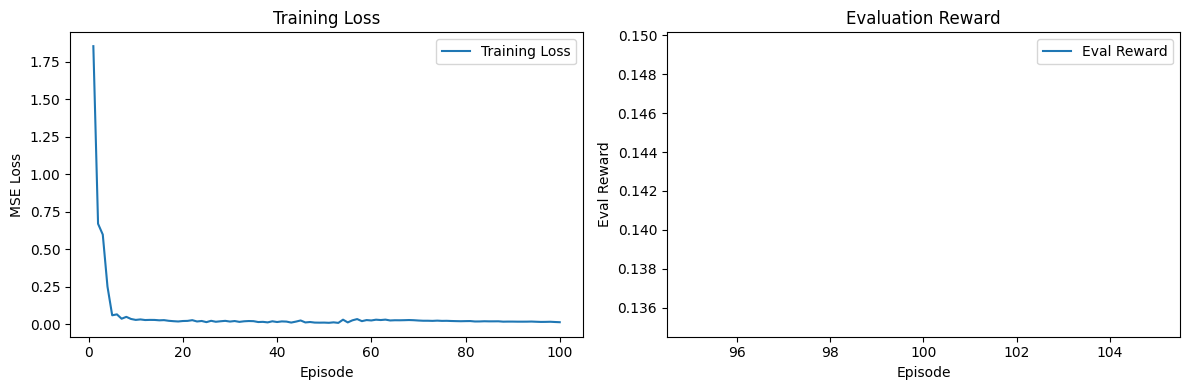

In [5]:
# Function to get teacher logits
@jax.jit
def get_teacher_logits(observations):
    # observations can be single or batched observation pytree
    param_subset = (teacher_params[0], teacher_params[1])
    return ppo_network.policy_network.apply(*param_subset, observations)

# Training function with MSE loss
def kl_train_step(params, opt_state, inputs, targets):
    def loss_fn(params):
        # Student predictions: (batch_size, 2 * action_size) -> (mu, raw_log_std)
        predictions = student_net.apply(params, inputs)  # (batch_size, 2 * action_size)
        mu_s = predictions[:, :action_size]  # (batch_size, action_size)
        raw_log_std_s = predictions[:, action_size:]  # (batch_size, action_size)
        std_s = jax.nn.softplus(raw_log_std_s) + 1e-8  # Ensure positive std

        # Teacher targets: (batch_size, 2 * action_size) -> (loc, scale)
        loc_t = targets[:, :action_size]  # (batch_size, action_size)
        scale_t = targets[:, action_size:]  # (batch_size, action_size)

        # KL divergence for Normal distributions (pre-tanh)
        # KL(N(mu1, sigma1) || N(mu2, sigma2)) = 0.5 * (log(sigma2/sigma1) + (sigma1^2 + (mu1-mu2)^2)/(2*sigma2^2) - 0.5)
        log_std_s = jnp.log(std_s + 1e-8)
        log_std_t = jnp.log(scale_t + 1e-8)
        kl_term = (
            log_std_t - log_std_s +
            (std_s**2 + (mu_s - loc_t)**2) / (2 * scale_t**2 + 1e-8) -
            0.5
        )
        loss = jnp.mean(kl_term)  # Mean over batch and action dims
        return loss

    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Training function with MSE loss
@jax.jit
def mse_train_step(params, opt_state, inputs, targets):
    def loss_fn(params):
        predictions = student_net.apply(params, inputs)
        loss = jnp.mean((predictions - targets) ** 2)
        return loss
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Training loop
training_losses = []
eval_rewards = []
eval_episodes = []
metrics_handle = None
video_handle = None

if loss_function_name == "mse":
    train_step = mse_train_step
elif loss_function_name == "kl":
    train_step = kl_train_step
else:
    print("LOSS Function NOT IMPLEMENTED")

key = jax.random.PRNGKey(seed)
for episode in range(episodes):
    key, env_key, act_key = jax.random.split(key, 3)
    # Reset num_envs in parallel
    env_keys = jax.random.split(env_key, num_envs)
    states = batched_reset(env_keys)

    # Generate a different random command for each environment: x~U(0,1), y~U(0,1), z=0
    act_key, cmd_key = jax.random.split(act_key)
    rand_xyz = jax.random.uniform(cmd_key, shape=(num_envs, 3), minval=0.0, maxval=1.0)
    # zeros_z = jnp.zeros((num_envs, 1))
    # command_batch = jnp.concatenate([rand_xy, zeros_z], axis=-1)  # (N, 3)
    command_batch = rand_xyz
    states.info["command"] = command_batch

    # Buffers: (T, N, ...)
    student_inputs = jnp.zeros((episode_length, num_envs, student_obs_dim))
    student_targets = jnp.zeros((episode_length, num_envs, 2 * action_size))

    for step in range(episode_length):
        # Teacher logits target on current states (batched)
        logits = get_teacher_logits(states.obs)  # (N, 2*A)

        obs_batch = states.obs[student_observation_key]  # (N, student_obs_dim)
        student_inputs = student_inputs.at[step].set(obs_batch)
        student_targets = student_targets.at[step].set(logits)
        
        if data_collection == "dagger":
            # DAgger: stepping on the Student action
            student_logits = student_net.apply(student_params, obs_batch)  # (N, 2*A)
            mu = student_logits[:, :action_size]
            actions = jnp.tanh(mu)  # (N, A)
        else:
            # Behaviour Cloning: stepping on the Teacher action
            act_rngs = jax.random.split(act_key, num_envs)  # Split RNG per env
            actions = batched_teacher_policy(states.obs, act_rngs)  # (N, A)
        states = batched_step(states, actions)
        states.info["command"] = command_batch

    # Flatten buffers to (T*N, ...)
    flat_inputs = student_inputs.reshape((-1, student_obs_dim))
    flat_targets = student_targets.reshape((-1, 2 * action_size))

    # Mini-batch SGD over collected data; use only full-sized minibatches to avoid recompilation
    total_samples = flat_inputs.shape[0]
    total_full = (total_samples // batch_size) * batch_size
    num_minibatches = max(1, total_full // batch_size)
    total_loss = 0.0
    for b in range(num_minibatches):
        start_idx = b * batch_size
        end_idx = start_idx + batch_size
        batch_in = flat_inputs[start_idx:end_idx]
        batch_tg = flat_targets[start_idx:end_idx]
        student_params, opt_state, loss = train_step(student_params, opt_state, batch_in, batch_tg)
        total_loss += loss
    avg_loss = total_loss / num_minibatches
    training_losses.append(float(avg_loss))

    if (episode + 1) % 100 == 0:
        # Student inference function: outputs logits for a batch; eval with B=1 for simplicity
        student_policy_fn = jax.jit(lambda obs, rng: student_net.apply(student_params, obs))
        eval_reward = evaluate_policy(env, student_policy_fn, act_key, steps=episode_length, B=1)
        eval_rewards.append(float(eval_reward))
        eval_episodes.append(episode + 1)

        global metrics_handle
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        axes[0].plot(range(1, len(training_losses) + 1), [float(x) for x in training_losses], label="Training Loss")
        axes[0].set_xlabel("Episode")
        axes[0].set_ylabel("MSE Loss")
        axes[0].legend()
        axes[0].set_title("Training Loss")
        axes[1].plot(eval_episodes, eval_rewards, label="Eval Reward")
        axes[1].set_xlabel("Episode")
        axes[1].set_ylabel("Eval Reward")
        axes[1].legend()
        axes[1].set_title("Evaluation Reward")
        plt.tight_layout()
        if metrics_handle is None:
            metrics_handle = display(fig, display_id=True)
        else:
            metrics_handle.update(fig)
        plt.close(fig)

    # Compute GIFs of the student performance
    if (episode + 1) % 500 == 0:
        env_cfg.pert_config.enable = True
        env_cfg.pert_config.velocity_kick = [3.0, 6.0]
        env_cfg.pert_config.kick_wait_times = [5.0, 15.0]
        env_cfg.command_config.a = [1.5, 0.8, 2*jnp.pi]
        eval_env = env
        velocity_kick_range = [0.0, 0.0]  # Disable velocity kick.
        kick_duration_range = [0.05, 0.2]

        jit_reset = jax.jit(eval_env.reset)
        jit_step = jax.jit(eval_env.step)
        student_policy_fn = jax.jit(lambda obs, rng: student_net.apply(student_params, obs))

        # Save policy parameters
        params_filename = os.path.join(experiment_path, f"student_params_{data_collection}_{loss_function_name}.npy")
        params_np = jax.tree.map(lambda x: np.array(x), student_params)
        np.save(params_filename, params_np, allow_pickle=True)
        # Loading back: to test if this works
        # loaded = np.load(params_filename, allow_pickle=True).item()
        # loaded_params = jax.tree.map(lambda x: jnp.array(x), loaded)
        # student_params = loaded_params

        # GIFs Evaluation
        x_vels = [0.0, 0.5, 1.0, 0.0, 0.0, 0.5]
        y_vels = [0.0, 0.0, 0.0, 0.5, 1.0, 0.5]
        yaw_vels = [1.0, 0.0, 0.0, 0.0, 0.0, 0.1]

        for run_id, (x_vel, y_vel, yaw_vel) in enumerate(zip(x_vels, y_vels, yaw_vels)):
            def sample_pert(rng):
                rng, key1, key2 = jax.random.split(rng, 3)
                pert_mag = jax.random.uniform(
                    key1, minval=velocity_kick_range[0], maxval=velocity_kick_range[1]
                )
                duration_seconds = jax.random.uniform(
                    key2, minval=kick_duration_range[0], maxval=kick_duration_range[1]
                )
                duration_steps = jnp.round(duration_seconds / eval_env.dt).astype(jnp.int32)
                state.info["pert_mag"] = pert_mag
                state.info["pert_duration"] = duration_steps
                state.info["pert_duration_seconds"] = duration_seconds
                return rng


            rng = jax.random.PRNGKey(0)
            rollout = []
            modify_scene_fns = []

            swing_peak = []
            rewards = []
            linvel = []
            angvel = []
            track = []
            foot_vel = []
            rews = []
            contact = []
            command = jnp.array([x_vel, y_vel, yaw_vel])

            state = jit_reset(rng)
            if state.info["steps_since_last_pert"] < state.info["steps_until_next_pert"]:
                rng = sample_pert(rng)
            state.info["command"] = command
            for _ in range(env_cfg.episode_length):
                if state.info["steps_since_last_pert"] < state.info["steps_until_next_pert"]:
                    rng = sample_pert(rng)
                act_rng, rng = jax.random.split(rng)
                student_obs = state.obs[student_observation_key].reshape(1, -1)
                student_logits = student_policy_fn(student_obs, rng)
                mu = student_logits[0, :env.action_size]
                ctrl_student = jnp.tanh(mu)
                state = jit_step(state, ctrl_student)
                state.info["command"] = command
                rews.append(
                    {k: v for k, v in state.metrics.items() if k.startswith("reward/")}
                )
                rollout.append(state)
                swing_peak.append(state.info["swing_peak"])
                rewards.append(
                    {k[7:]: v for k, v in state.metrics.items() if k.startswith("reward/")}
                )
                linvel.append(env.get_global_linvel(state.data))
                angvel.append(env.get_gyro(state.data))
                track.append(
                    env._reward_tracking_lin_vel(
                        state.info["command"], env.get_local_linvel(state.data)
                    )
                )

                feet_vel = state.data.sensordata[env._foot_linvel_sensor_adr]
                vel_xy = feet_vel[..., :2]
                vel_norm = jnp.sqrt(jnp.linalg.norm(vel_xy, axis=-1))
                foot_vel.append(vel_norm)

                contact.append(state.info["last_contact"])

                xyz = np.array(state.data.xpos[env._torso_body_id])
                xyz += np.array([0, 0, 0.2])
                x_axis = state.data.xmat[env._torso_body_id, 0]
                yaw = -np.arctan2(x_axis[1], x_axis[0])
                modify_scene_fns.append(
                    functools.partial(
                        draw_joystick_command,
                        cmd=state.info["command"],
                        xyz=xyz,
                        theta=yaw,
                        scl=abs(state.info["command"][0])
                        / env_cfg.command_config.a[0],
                    )
                )


            render_every = 2
            fps = 1.0 / eval_env.dt / render_every
            traj = rollout[::render_every]
            mod_fns = modify_scene_fns[::render_every]

            scene_option = mujoco.MjvOption()
            scene_option.geomgroup[2] = True
            scene_option.geomgroup[3] = False
            scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
            scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
            scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = True

            frames = eval_env.render(
                traj,
                camera="track",
                scene_option=scene_option,
                width=640,
                height=480,
                modify_scene_fns=mod_fns,
            )
            media.show_video(frames, fps=fps)

            i_gif_name = os.path.join(experiment_path, f"teacher_student_{run_id}.gif")
            imageio.mimsave(i_gif_name, frames, duration=1.0 / fps)

## Evaluation, from utils.py, changing how we compute the action!

In [ ]:
env_cfg.pert_config.enable = True
env_cfg.pert_config.velocity_kick = [3.0, 6.0]
env_cfg.pert_config.kick_wait_times = [5.0, 15.0]
env_cfg.command_config.a = [1.5, 0.8, 2*jnp.pi]
eval_env = env
velocity_kick_range = [0.0, 0.0]  # Disable velocity kick.
kick_duration_range = [0.05, 0.2]

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)
student_policy_fn = jax.jit(lambda obs, rng: student_net.apply(student_params, obs))

x_vels = [0.0, 0.5, 1.0, 0.0, 0.0, 0.5]
y_vels = [0.0, 0.0, 0.0, 0.5, 1.0, 0.5]
yaw_vels = [1.0, 0.0, 0.0, 0.0, 0.0, 0.1]

for run_id, (x_vel, y_vel, yaw_vel) in enumerate(zip(x_vels, y_vels, yaw_vels)):
    def sample_pert(rng):
        rng, key1, key2 = jax.random.split(rng, 3)
        pert_mag = jax.random.uniform(
            key1, minval=velocity_kick_range[0], maxval=velocity_kick_range[1]
        )
        duration_seconds = jax.random.uniform(
            key2, minval=kick_duration_range[0], maxval=kick_duration_range[1]
        )
        duration_steps = jnp.round(duration_seconds / eval_env.dt).astype(jnp.int32)
        state.info["pert_mag"] = pert_mag
        state.info["pert_duration"] = duration_steps
        state.info["pert_duration_seconds"] = duration_seconds
        return rng


    rng = jax.random.PRNGKey(0)
    rollout = []
    modify_scene_fns = []

    swing_peak = []
    rewards = []
    linvel = []
    angvel = []
    track = []
    foot_vel = []
    rews = []
    contact = []
    command = jnp.array([x_vel, y_vel, yaw_vel])

    state = jit_reset(rng)
    if state.info["steps_since_last_pert"] < state.info["steps_until_next_pert"]:
        rng = sample_pert(rng)
    state.info["command"] = command
    for _ in range(env_cfg.episode_length):
        if state.info["steps_since_last_pert"] < state.info["steps_until_next_pert"]:
            rng = sample_pert(rng)
        act_rng, rng = jax.random.split(rng)
        student_obs = state.obs[student_observation_key].reshape(1, -1)
        student_logits = student_policy_fn(student_obs, rng)
        mu = student_logits[0, :env.action_size]
        ctrl_student = jnp.tanh(mu)
        state = jit_step(state, ctrl_student)
        state.info["command"] = command
        rews.append(
            {k: v for k, v in state.metrics.items() if k.startswith("reward/")}
        )
        rollout.append(state)
        swing_peak.append(state.info["swing_peak"])
        rewards.append(
            {k[7:]: v for k, v in state.metrics.items() if k.startswith("reward/")}
        )
        linvel.append(env.get_global_linvel(state.data))
        angvel.append(env.get_gyro(state.data))
        track.append(
            env._reward_tracking_lin_vel(
                state.info["command"], env.get_local_linvel(state.data)
            )
        )

        feet_vel = state.data.sensordata[env._foot_linvel_sensor_adr]
        vel_xy = feet_vel[..., :2]
        vel_norm = jnp.sqrt(jnp.linalg.norm(vel_xy, axis=-1))
        foot_vel.append(vel_norm)

        contact.append(state.info["last_contact"])

        xyz = np.array(state.data.xpos[env._torso_body_id])
        xyz += np.array([0, 0, 0.2])
        x_axis = state.data.xmat[env._torso_body_id, 0]
        yaw = -np.arctan2(x_axis[1], x_axis[0])
        modify_scene_fns.append(
            functools.partial(
                draw_joystick_command,
                cmd=state.info["command"],
                xyz=xyz,
                theta=yaw,
                scl=abs(state.info["command"][0])
                / env_cfg.command_config.a[0],
            )
        )


    render_every = 2
    fps = 1.0 / eval_env.dt / render_every
    traj = rollout[::render_every]
    mod_fns = modify_scene_fns[::render_every]

    scene_option = mujoco.MjvOption()
    scene_option.geomgroup[2] = True
    scene_option.geomgroup[3] = False
    scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
    scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
    scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = True

    frames = eval_env.render(
        traj,
        camera="track",
        scene_option=scene_option,
        width=640,
        height=480,
        modify_scene_fns=mod_fns,
    )
    media.show_video(frames, fps=fps)

In [ ]:
# Comparison visualization function
# Uses a persistent display handle so the video remains visible until replaced

def compare_teacher_student_gifs(
    env,
    jit_reset,
    jit_step,
    teacher_policy_fn,
    student_policy_fn,
    student_params,
    episode_length,
    command,
    seed,
    width=640,
    height=480,
    fps=30,
    render_every=2,
):
    global video_handle
    scene_option = mujoco.MjvOption()
    scene_option.geomgroup[2] = True
    scene_option.geomgroup[3] = False
    scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
    scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
    scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = True
    key = jax.random.PRNGKey(seed)
    key_teacher, key_student, key_env = jax.random.split(key, 3)
    state_teacher = jit_reset(key_env)
    state_student = jit_reset(key_env)
    state_teacher.info["command"] = command
    state_student.info["command"] = command
    rollout_teacher = []
    rollout_student = []
    modify_scene_fns_teacher = []
    modify_scene_fns_student = []
    for _ in range(episode_length):
        # Teacher: expects full observation tree
        act_rng_teacher, key_teacher = jax.random.split(key_teacher)
        ctrl_teacher, _ = teacher_policy_fn(state_teacher.obs, act_rng_teacher)
        state_teacher = jit_step(state_teacher, ctrl_teacher)
        state_teacher.info["command"] = command
        rollout_teacher.append(state_teacher)
        # Student: logits -> tanh(mu) actions
        act_rng_student, key_student = jax.random.split(key_student)
        student_obs = state_student.obs[student_observation_key].reshape(1, -1)
        student_logits = student_policy_fn(student_obs, act_rng_student)
        mu = student_logits[0, :env.action_size]
        ctrl_student = jnp.tanh(mu)
        state_student = jit_step(state_student, ctrl_student)
        state_student.info["command"] = command
        rollout_student.append(state_student)
        for st, mod_list in [
            (state_teacher, modify_scene_fns_teacher),
            (state_student, modify_scene_fns_student),
        ]:
            xyz = np.array(st.data.xpos[env._torso_body_id])
            xyz += np.array([0, 0, 0.2])
            x_axis = st.data.xmat[env._torso_body_id, 0]
            yaw = -np.arctan2(x_axis[1], x_axis[0])
            mod_list.append(
                functools.partial(
                    draw_joystick_command,
                    cmd=st.info["command"],
                    xyz=xyz,
                    theta=yaw,
                    scl=abs(st.info["command"][0]) / env_cfg.command_config.a[0],
                )
            )
    traj_teacher = rollout_teacher[::render_every]
    traj_student = rollout_student[::render_every]
    mod_fns_teacher = modify_scene_fns_teacher[::render_every]
    mod_fns_student = modify_scene_fns_student[::render_every]
    # Use env.render which is implemented to render offscreen with EGL
    frames_teacher = env.render(
        traj_teacher,
        camera="track",
        scene_option=scene_option,
        width=width,
        height=height,
        modify_scene_fns=mod_fns_teacher,
    )
    frames_student = env.render(
        traj_student,
        camera="track",
        scene_option=scene_option,
        width=width,
        height=height,
        modify_scene_fns=mod_fns_student,
    )
    teacher_gif_path = "teacher_policy.gif"
    student_gif_path = "student_policy.gif"
    # Ensure frames are uint8
    frames_teacher = [np.asarray(f, dtype=np.uint8) for f in frames_teacher]
    frames_student = [np.asarray(f, dtype=np.uint8) for f in frames_student]
    imageio.mimsave(teacher_gif_path, frames_teacher, fps=fps, loop=0)
    imageio.mimsave(student_gif_path, frames_student, fps=fps, loop=0)
    def gif_to_base64(gif_path):
        with open(gif_path, "rb") as f:
            encoded = base64.b64encode(f.read()).decode("ascii")
        return f"data:image/gif;base64,{encoded}"
    teacher_base64 = gif_to_base64(teacher_gif_path)
    student_base64 = gif_to_base64(student_gif_path)
    html = f"""
    <div style="display: flex; justify-content: center;">
        <div style="margin-right: 10px; text-align: center;">
            <h3>Teacher Policy</h3>
            <img src="{teacher_base64}" width="{width}" height="{height}"/>
        </div>
        <div style="text-align: center;">
            <h3>Student Policy</h3>
            <img src="{student_base64}" width="{width}" height="{height}"/>
        </div>
    </div>
    """
    
    if video_handle is None:
        video_handle = display(HTML(html), display_id=True)
    else:
        video_handle.update(HTML(html))

    os.remove(teacher_gif_path)
    os.remove(student_gif_path)